<a href="https://colab.research.google.com/github/guupys/Colab-notebook/blob/main/TEST_Adapting_Domein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 参照元
https://gmihaila.medium.com/fine-tune-transformers-in-pytorch-using-transformers-57b40450635

# Download

Download the Large Movie Review Dataset and unzip it locally.

In [ ]:
# Download the dataset.
!wget -q -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# -qは経過情報の出力無し  -ncはファイルが既存の場合に上書きしない
# Unzip the dataset.
!tar -zxf /content/aclImdb_v1.tar.gz

# **Installs**

* **[transformers](https://github.com/huggingface/transformers)** library needs to be installed to use all the awesome code from Hugging Face. To get the latest version I will install it straight from GitHub.

* **[ml_things](https://github.com/gmihaila/ml_things)** library used for various machine learning related tasks. I created this library to reduce the amount of code I need to write for each machine learning project.

In [ ]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git   

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 12.1 MB/s 
     |████████████████████████████████| 6.8 MB 42.3 MB/s 
     |████████████████████████████████| 895 kB 23.2 MB/s 
     |████████████████████████████████| 61 kB 558 kB/s 
     |████████████████████████████████| 64 kB 2.5 MB/s 
     |████████████████████████████████| 11.2 MB 17.4 MB/s 
     |████████████████████████████████| 890 kB 43.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Import

In [ ]:
import io
import os
import math
import torch
import warnings
from tqdm.notebook import tqdm
from ml_things import plot_dict, fix_text   # 特に使わなくても問題は無さそう
from transformers import (
                          CONFIG_MAPPING,
                          MODEL_FOR_MASKED_LM_MAPPING,
                          MODEL_FOR_CAUSAL_LM_MAPPING,
                          PreTrainedTokenizer,
                          TrainingArguments,
                          AutoConfig,
                          AutoTokenizer,
                          AutoModelWithLMHead,
                          AutoModelForCausalLM,
                          AutoModelForMaskedLM,
                          LineByLineTextDataset,
                          TextDataset,
                          DataCollatorForLanguageModeling,
                          DataCollatorForWholeWordMask,
                          DataCollatorForPermutationLanguageModeling,
                          PretrainedConfig,
                          Trainer,
                          set_seed,
                          )

# Set seed for reproducibility,
set_seed(123)

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Helper Functions**

**movie_reviews_to_file(path_data: str, path_texts_file: str)**

This function to put multiple files in a single `.txt` file.<br>
`path_data` points to the path where data files are present.<br> `path_texts_file` will be the `.txt` file containing all data.

In [ ]:
def movie_reviews_to_file(path_data: str, path_texts_file: str):
  # Check if path exists.
  if not os.path.isdir(path_data):
    raise ValueError('Invalid `path` variable! Needs to be a directory')
  texts = []
  print('Reading `%s` partition...' % (os.path.basename(path_data)))
  for label  in ['neg', 'pos']:
    sentiment_path = os.path.join(path_data, label)
    files_names = os.listdir(sentiment_path)#[:30] # SAMPLE FOR DEBUGGING.
    for file_name in tqdm(files_names, desc=label, unit='files'):
      file_path = os.path.join(sentiment_path, file_name)
      content = open(file_path, mode='r', encoding='utf-8').read()
      #content = fix_text(content)    # Fix any unicode issues. (文字化け削除)
      texts.append(content)
  all_texts = '\n'.join(texts)
  open(file=path_texts_file, mode='w', encoding='utf-8').write(all_texts)
  print('`.txt` file saved in `%s`\n' % path_texts_file)
  return

**ModelDataArguments**

This class follows similar format as the [transformers]((https://github.com/huggingface/transformers) library. The main difference is the way I combined multiple types of arguments into one and used rules to make sure the arguments used are correctly set. Here are all argument detailed (they are also mentioned in the class documentation):

* `train_data_file`: 
  *Path to your `.txt` file dataset. If you have an example on each line of the file make sure to use `line_by_line=True`. If the data file contains all text data without any special grouping use `line_by_line=False` to move a `block_size` window across the text file.*

* `eval_data_file`: 
  *Path to evaluation `.txt` file. It has the same format as `train_data_file`.*

* `line_by_line`: 
  *If the `train_data_file` and `eval_data_file` contains separate examples 
  on each line set `line_by_line=True`.
  If there is no separation between examples and `train_data_file` and 
  `eval_data_file` contains continuous text then `line_by_line=False` and a 
  window of `block_size` will be moved across the files to acquire examples.*

* `mlm`: 
  *Is a flag that changes loss function depending on model architecture. 
  This variable needs to be set to `True` when working with masked language 
  models like bert or roberta and set to `False` otherwise. There are functions that will raise ValueError if this argument is not set accordingly.*

* `whole_word_mask`:
  *Used as flag to determine if we decide to use whole word masking or not. Whole word masking means that whole words will be masked during training instead of tokens which can be chunks of words.*

* `mlm_probability`: 
  *Used when training masked language models. Needs to have `mlm=True`. 
  It represents the probability of masking tokens when training model.*

* `plm_probability`: 
  *Flag to define the ratio of length of a span of masked 
  tokens to surrounding context length for permutation language modeling. Used for XLNet.*

* `max_span_length`: 
  *Flag may also be used to limit the length of a span of 
  masked tokens used for permutation language modeling.
  Used for XLNet.*

* `block_size`: 
  *It refers to the windows size that is moved across the text file. Set to -1 to use maximum allowed length.*

* `overwrite_cache`: 
  *If there are any cached files, overwrite them.*

* `model_type`: 
  *Type of model used: bert, roberta, gpt2. 
  More details [here](https://huggingface.co/transformers/pretrained_models.html).*

* `model_config_name`:
  *Config of model used: bert, roberta, gpt2. 
  More details [here](https://huggingface.co/transformers/pretrained_models.html).*

* `tokenizer_name`:
  *Tokenizer used to process data for training the model. 
  It usually has same name as `model_name_or_path`: bert-base-cased, 
  roberta-base, gpt2 etc.*

* `model_name_or_path`: 
  *Path to existing transformers model or name of 
  transformer model to be used: bert-base-cased, roberta-base, gpt2 etc. 
  More details [here](https://huggingface.co/transformers/pretrained_models.html).*

* `model_cache_dir`: 
  *Path to cache files. It helps to save time when re-running code.*

In [ ]:
class ModelDataArguments(object):
  def __init__(self, train_data_file=None, eval_data_file=None, 
               line_by_line=False, mlm=False, mlm_probability=0.15, 
               whole_word_mask=False, plm_probability=float(1/6), 
               max_span_length=5, block_size=-1, overwrite_cache=False, 
               model_type=None, model_config_name=None, tokenizer_name=None, 
               model_name_or_path=None, model_cache_dir=None):
    
    # Make sure CONFIG_MAPPING is imported from transformers module.
    if 'CONFIG_MAPPING' not in globals():
      raise ValueError('Could not find `CONFIG_MAPPING` imported! Make sure' \
                       ' to import it from `transformers` module!')
    # Make sure model_type is valid.
    if (model_type is not None) and (model_type not in CONFIG_MAPPING.keys()):
      raise ValueError('Invalid `model_type`! Use one of the following: %s' % 
                       (str(list(CONFIG_MAPPING.keys())))) 
    # variables are not all `None`.
    if not any([model_type, model_config_name, model_name_or_path]):
      raise ValueError('You can`t have all `model_type`, `model_config_name`,' \
                       ' `model_name_or_path` be `None`! You need to have' \
                       'at least one of them set!')
    
    # Check if a new model will be loaded from scratch.
    if not any([model_config_name, model_name_or_path]):
      warnings.warn('You are planning to train a model from scratch!')

    # Can't train tokenizer from scratch here! Raise error.
    if not any([tokenizer_name, model_name_or_path]):
      raise ValueError('You want to train tokenizer from scratch! ' \
                    'That is not possible yet! You can train your own ' \
                    'tokenizer separately and use path here to load it!')
      
    # Set all data related arguments.
    self.train_data_file = train_data_file
    self.eval_data_file = eval_data_file
    self.line_by_line = line_by_line
    self.mlm = mlm
    self.whole_word_mask = whole_word_mask
    self.mlm_probability = mlm_probability
    self.plm_probability = plm_probability
    self.max_span_length = max_span_length
    self.block_size = block_size
    self.overwrite_cache = overwrite_cache

    # Set all model and tokenizer arguments.
    self.model_type = model_type
    self.model_config_name = model_config_name
    self.tokenizer_name = tokenizer_name
    self.model_name_or_path = model_name_or_path
    self.model_cache_dir = model_cache_dir
    return

**get_model_config(args: ModelDataArguments)**

Get model configuration. Using the ModelDataArguments to return the model configuration. Here are all argument detailed:

* `args`: *Model and data configuration arguments needed to perform pretraining.*

* Returns: *Model transformers configuration.*

* Raises: *ValueError: If `mlm=True` and `model_type` is NOT in ["bert", "roberta", "distilbert", "camembert"]. We need to use a masked language model in order to set `mlm=True`.*

In [ ]:
def get_model_config(args: ModelDataArguments):
  # Check model configuration.
  if args.model_config_name is not None:
    # Use model configure name if defined.
    model_config = AutoConfig.from_pretrained(args.model_config_name, 
                                      cache_dir=args.model_cache_dir)
  elif args.model_name_or_path is not None:
    # Use model name or path if defined.
    model_config = AutoConfig.from_pretrained(args.model_name_or_path, 
                                      cache_dir=args.model_cache_dir)
  else:
    # Use config mapping if building model from scratch.
    model_config = CONFIG_MAPPING[args.model_type]()

  # Make sure `mlm` flag is set for Masked Language Models (MLM).
  if (model_config.model_type in ["bert", "roberta", "distilbert", 
                                  "camembert"]) and (args.mlm is False):
    raise ValueError('BERT and RoBERTa-like models do not have LM heads ' \
                    'butmasked LM heads. They must be run setting `mlm=True`')
  
  # Adjust block size for xlnet.
  if model_config.model_type == "xlnet":  
    args.block_size = 512   # xlnet used 512 tokens when training.
    model_config.mem_len = 1024   # setup memory length
  
  return model_config

**get_tokenizer(args: ModelDataArguments)**

Get model tokenizer.Using the ModelDataArguments return the model tokenizer and change `block_size` form `args` if needed. Here are all argument detailed:

* `args`: *Model and data configuration arugments needed to perform pretraining.*

* Returns: *Model transformers tokenizer.*

In [ ]:
def get_tokenizer(args: ModelDataArguments):
  # Check tokenizer configuration.
  if args.tokenizer_name:
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, 
                                              cache_dir=args.model_cache_dir)

  elif args.model_name_or_path:
    tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path, 
                                              cache_dir=args.model_cache_dir)
  # Setp data block size.
  if args.block_size <= 0:
    # Set block size to maximum length of tokenizer.
    # Input block size will be the max possible for the model.
    # Some max lengths are very large and will cause a
    args.block_size = tokenizer.model_max_length
  else:
    # Never go beyond tokenizer maximum length.
    args.block_size = min(args.block_size, tokenizer.model_max_length)

  return tokenizer

**get_model(args: ModelDataArguments, model_config)**

Get model. Using the ModelDataArguments return the actual model. Here are all argument detailed:

* `args`: *Model and data configuration arguments needed to perform pretraining.*

* `model_config`: *Model transformers configuration.*

* Returns: *PyTorch model.*

In [ ]:
def get_model(args: ModelDataArguments, model_config):
  # Make sure MODEL_FOR_MASKED_LM_MAPPING and MODEL_FOR_CAUSAL_LM_MAPPING are imported from transformers module.
  if ('MODEL_FOR_MASKED_LM_MAPPING' not in globals()) and \
                ('MODEL_FOR_CAUSAL_LM_MAPPING' not in globals()):
    raise ValueError('Could not find `MODEL_FOR_MASKED_LM_MAPPING` and' \
                     ' `MODEL_FOR_MASKED_LM_MAPPING` imported! Make sure to' \
                     ' import them from `transformers` module!')  
  # Check if using pre-trained model or train from scratch.
  if args.model_name_or_path:
    # Use pre-trained model.
    if type(model_config) in MODEL_FOR_MASKED_LM_MAPPING.keys():
      # Masked language modeling head.
      return AutoModelForMaskedLM.from_pretrained(
                        args.model_name_or_path,
                        from_tf=bool(".ckpt" in args.model_name_or_path),
                        config=model_config,
                        cache_dir=args.model_cache_dir,
                        )
    elif type(model_config) in MODEL_FOR_CAUSAL_LM_MAPPING.keys():
      # Causal language modeling head.
      return AutoModelForCausalLM.from_pretrained(
                                          args.model_name_or_path, 
                                          from_tf=bool(".ckpt" in 
                                                        args.model_name_or_path),
                                          config=model_config, 
                                          cache_dir=args.model_cache_dir)
    else:
      raise ValueError(
          'Invalid `model_name_or_path`! It should be in %s or %s!' % 
          (str(MODEL_FOR_MASKED_LM_MAPPING.keys()), 
           str(MODEL_FOR_CAUSAL_LM_MAPPING.keys())))
    
  else:
    # Use model from configuration - train from scratch.
      print("Training new model from scratch!")
      return AutoModelWithLMHead.from_config(config)

**get_dataset(args: ModelDataArguments, tokenizer: PreTrainedTokenizer, evaluate: bool=False)**

Process dataset file into PyTorch Dataset. Using the ModelDataArguments return the actual model. Here are all argument detailed:

* `args`: *Model and data configuration arguments needed to perform pretraining.*

* `tokenizer`: *Model transformers tokenizer.*

* `evaluate`: *If set to `True` the test / validation file is being handled. If set to `False` the train file is being handled.*

* Returns: *PyTorch Dataset that contains file's data.*

In [ ]:
def get_dataset(args: ModelDataArguments, tokenizer: PreTrainedTokenizer, 
                evaluate: bool=False):
  # Get file path for either train or evaluate.
  file_path = args.eval_data_file if evaluate else args.train_data_file
  # Check if `line_by_line` flag is set to `True`.
  if args.line_by_line:
    # Each example in data file is on each line.
    return LineByLineTextDataset(tokenizer=tokenizer, file_path=file_path, 
                                 block_size=args.block_size)   
  else:
    # All data in file is put together without any separation.
    return TextDataset(tokenizer=tokenizer, file_path=file_path, 
                       block_size=args.block_size, 
                       overwrite_cache=args.overwrite_cache)

**get_collator(args: ModelDataArguments, model_config: PretrainedConfig, tokenizer: PreTrainedTokenizer)**

Get appropriate collator function.
Collator function will be used to collate a PyTorch Dataset object. Here are all argument detailed:

* `args`: *Model and data configuration arguments needed to perform pretraining.*

* `model_config`: *Model transformers configuration.*

* `tokenizer`: *Model transformers tokenizer.*

* Returns: *Transformers specific data collator.*

In [ ]:
def get_collator(args: ModelDataArguments, model_config: PretrainedConfig, 
                 tokenizer: PreTrainedTokenizer):
  if model_config.model_type == "xlnet":
    # Configure collator for XLNET.
    return DataCollatorForPermutationLanguageModeling(
                                          tokenizer=tokenizer,
                                          plm_probability=args.plm_probability,
                                          max_span_length=args.max_span_length,
                                          )
  else:
    # Configure data for rest of model types.
    if args.mlm and args.whole_word_mask:
      # Use whole word masking.
      return DataCollatorForWholeWordMask(
                                          tokenizer=tokenizer, 
                                          mlm_probability=args.mlm_probability,
                                          )
    else:
      # Regular language modeling.
      return DataCollatorForLanguageModeling(
                                          tokenizer=tokenizer, 
                                          mlm=args.mlm, 
                                          mlm_probability=args.mlm_probability,
                                          )

# **Parameters Setup**

Declare the rest of the parameters used for this notebook:

* `model_data_args` contains all arguments needed to setup dataset, model configuration, model tokenizer and the actual model. This is created using the `ModelDataArguments` class.

* `training_args` contain all arguments needed to use the [Trainer]() functionality from Transformers that allows us to train transformers models in PyTorch very easy. You can find the complete documentation [here](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments). There are a lot of parameters that can be set to allow multiple functionalities. I only used the following parameters (the comments are inspired from the HuggingFace documentation of [TrainingArguments](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments):
 
  * `output_dir`: *The output directory where the model predictions and checkpoints will be written. I set it up to `pretrained_bert_model` where the model and will be saved.*

  * `overwrite_output_dir`: *Overwrite the content of the output directory. I set it to `True` in case I run the notebook multiple times I only care about the last run.*

  * `do_train`: *Whether to run training or not. I set this parameter to `True` because I want to train the model on my custom dataset.* 

  * `do_eval`: *Whether to run evaluation on the evaluation files or not.
I set it to `True` since I have test data file and I want to evaluate how well the model trains.*

  * `per_device_train_batch_size`: *Batch size GPU/TPU core/CPU training. I set it to `2` for this example. I recommend setting it up as high as your GPU memory allows you.*

  * `per_device_eval_batch_size`: *Batch size  GPU/TPU core/CPU for evaluation.I set this value to `100` since it's not dealing with gradients.*

  * `evaluation_strategy`: *Evaluation strategy to adopt during training: `no`: No evaluation during training; `steps`: Evaluate every `eval_steps; `epoch`: Evaluate every end of epoch. I set it to 'steps' since I want to evaluate model more often.*

  * `logging_steps`: *How often to show logs. I will see this to plot history loss and calculate perplexity. I set this to `20` just as an example. If your evaluate data is large you might not want to run it that often because it will significantly slow down training time.*

  * `eval_steps`: *Number of update steps between two evaluations if evaluation_strategy="steps". Will default to the same value as logging_steps if not set. Since I want to evaluate model ever`logging_steps` I will set this to `None` since it will inherit same value as `logging_steps`.*

  * `prediction_loss_only`: *Set prediction loss to `True` in order to return loss for perplexity calculation. Since I want to calculate perplexity I set this to `True` since I want to monitor loss and perplexity (which is exp(loss)).*

  * `learning_rate`: *The initial learning rate for Adam. Defaults is set to `5e-5`.*

  * `weight_decay`: *The weight decay to apply (if not zero)Defaults is set to `0`.*

  * `adam_epsilon`: *Epsilon for the Adam optimizer. Defaults to `1e-8`.*

  * `max_grad_norm`: *Maximum gradient norm (for gradient clipping). Defaults to `0`.*

  * `num_train_epochs`: *Total number of training epochs to perform (if not an integer, will perform the decimal part percents of the last epoch before stopping training). I set it to `2` at most. Since the custom dataset will be a lot smaller than the original dataset the model was trained on we don't want to overfit.*

  * `save_steps`: *Number of updates steps before two checkpoint saves. Defaults to `500`.*

In [ ]:
# Define arguments for data, tokenizer and model arguments.
model_data_args = ModelDataArguments(
                                    train_data_file='/content/train.txt', 
                                    eval_data_file='/content/test.txt', 
                                    line_by_line=True, 
                                    mlm=True,
                                    whole_word_mask=True,
                                    mlm_probability=0.15,
                                    plm_probability=float(1/6), 
                                    max_span_length=5,
                                    block_size=50, 
                                    overwrite_cache=False, 
                                    model_type='bert', 
                                    model_config_name='bert-base-cased', 
                                    tokenizer_name='bert-base-cased', 
                                    model_name_or_path='bert-base-cased', 
                                    model_cache_dir=None,
                                    )

# Define arguments for training
training_args = TrainingArguments(
                          # The output directory where the model predictions and checkpoints will be written.
                          output_dir='pretrain_bert',
                          # Overwrite the content of the output directory.
                          overwrite_output_dir=True,

                          # Whether to run training or not.
                          do_train=True, 
                          # Whether to run evaluation on the dev or not.
                          do_eval=True,
                          
                          # Batch size GPU/TPU core/CPU training.
                          per_device_train_batch_size=10,
                          # Batch size  GPU/TPU core/CPU for evaluation.
                          per_device_eval_batch_size=100,
                          # evaluation strategy to adopt during training
                          evaluation_strategy='steps',   # [`no`, `steps`, `epoch`]

                          # How often to show logs. I will se this to plot history loss and calculate perplexity.
                          logging_steps=1000,
                          # Number of update steps between two evaluations if evaluation_strategy="steps".
                          eval_steps = None,
                          
                          # Set prediction loss to `True` in order to return loss for perplexity calculation.
                          prediction_loss_only=True,

                          # The initial learning rate for Adam. 
                          learning_rate = 5e-5,
                          # The weight decay to apply (if not zero).
                          weight_decay=0,
                          # Epsilon for the Adam optimizer. 
                          adam_epsilon = 1e-8,
                          # Maximum gradient norm (for gradient clipping). Defaults to 0.
                          max_grad_norm = 1.0,
                          # Total number of training epochs to perform 
                          num_train_epochs = 1,

                          # Number of updates steps before two checkpoint saves. 
                          save_steps = 500,
                          )

# **Load Configuration, Tokenizer and Model**

Loading the three essential parts of the pretrained transformers: configuration, tokenizer and model. 

Since I use the AutoClass functionality from Hugging Face I only need to worry about the model's name as input and the rest is handled by the transformers library.

I will be calling each three functions created in the **Helper Functions** tab that help return `config` of the model, `tokenizer` of the model and the actual PyTorch `model`.

After `model` is loaded is always good practice to resize the model depending on the `tokenizer` size. This means that the tokenizer's vocabulary will be aligned with the models embedding layer. This is very useful when we have a different tokenizer that the pretrained one or we train a transformer model from scratch.

In [ ]:
# Load model configuration.
print('Loading model configuration...')
config = get_model_config(model_data_args)

# Load model tokenizer.
print('Loading model`s tokenizer...')
tokenizer = get_tokenizer(model_data_args)

# Loading model.
print('Loading actual model...')
model = get_model(model_data_args, config)

# Resize model to fit all tokens in tokenizer.
model.resize_token_embeddings(len(tokenizer))

Loading model configuration...


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Loading model`s tokenizer...


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Loading actual model...


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(28996, 768, padding_idx=0)

# **Dataset and Collator**

This is where I create the PyTorch Dataset and data collator objects that will be used to feed data into our model.

This is where I use the MovieReviewsDataset text files created with the `movie_reviews_to_file` function. Since data is partitioned for both train and test I will create two text files: one used for train and one used for evaluation. 

I strongly recommend to use a validation text file in order to determine how much training is needed in order to avoid overfitting. After you figure out what parameters yield the best results, the validation file can be incorporated in train and run a final train with the whole dataset.

The data collator is used to format the PyTorch Dataset outputs to match the output of our specific transformers model: i.e. for Bert it will created the masked tokens needed to train.

In [ ]:
# Create texts file from train data.
movie_reviews_to_file(path_data='/content/aclImdb/train', path_texts_file='/content/train.txt')
# Create texts file from test data.
movie_reviews_to_file(path_data='/content/aclImdb/test', path_texts_file='/content/test.txt')

# Setup train dataset if `do_train` is set.
print('Creating train dataset...')
train_dataset = get_dataset(model_data_args, tokenizer=tokenizer, evaluate=False) if training_args.do_train else None
# Setup evaluation dataset if `do_eval` is set.
print('Creating evaluate dataset...')
eval_dataset = get_dataset(model_data_args, tokenizer=tokenizer, evaluate=True) if training_args.do_eval else None
# Get data collator to modify data format depending on type of model used.
data_collator = get_collator(model_data_args, config, tokenizer)

# Display warning to user if the logging steps that will be displayed is larger than 100.
if (len(train_dataset) // training_args.per_device_train_batch_size \
    // training_args.logging_steps * training_args.num_train_epochs) > 100:
  # Display warning.
  warnings.warn('Your `logging_steps` value will will do a lot of printing!' \
                ' Consider increasing `logging_steps` to avoid overflowing' \
                ' the notebook with a lot of prints!')

Reading `train` partition...


neg:   0%|          | 0/12500 [00:00<?, ?files/s]

pos:   0%|          | 0/12500 [00:00<?, ?files/s]

`.txt` file saved in `/content/train.txt`

Reading `test` partition...


neg:   0%|          | 0/12500 [00:00<?, ?files/s]

pos:   0%|          | 0/12500 [00:00<?, ?files/s]

`.txt` file saved in `/content/test.txt`

Creating train dataset...


/usr/local/lib/python3.7/dist-packages/transformers/data/datasets/language_modeling.py:125: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


Creating evaluate dataset...


# **Train**

Hugging Face was very nice to us for creating the `Trainer` class. This helps make PyTorch model training of transformers very easy! We just need to make sure we loaded the proper parameters and everything else is taking care of!

At the end of the training the tokenizer is saved along with the model so you can easily re-use it later or even load in on Hugging Face Models.

I configured the arguments to display both train and validation loss at every `logging_steps`. It gives us a sense of how well the model is trained.

In [ ]:
# Initialize Trainer.
print('Loading `trainer`...')
trainer = Trainer(model=model,
                  args=training_args,
                  data_collator=data_collator,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset,
                  )
# Check model path to save.
if training_args.do_train:
  print('Start training...')
  # Setup model path if the model to train loaded from a local path.
  model_path = (model_data_args.model_name_or_path 
                if model_data_args.model_name_or_path is not None and 
                os.path.isdir(model_data_args.model_name_or_path) 
                else None
                )
  # Run training.
  trainer.train(model_path=model_path)
  # Save model.
  trainer.save_model()

  # For convenience, we also re-save the tokenizer to the same directory,
  # so that you can share your model easily on huggingface.co/models =).
  if trainer.is_world_process_zero():
    tokenizer.save_pretrained(training_args.output_dir)

Loading `trainer`...


/usr/local/lib/python3.7/dist-packages/transformers/trainer.py:1066: FutureWarning: `model_path` is deprecated and will be removed in a future version. Use `resume_from_checkpoint` instead.
  FutureWarning,
***** Running training *****
  Num examples = 25648
  Num Epochs = 1
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2565


Start training...


Step,Training Loss,Validation Loss
1000,2.757600,2.544835
2000,2.596600,2.459823


Saving model checkpoint to pretrain_bert/checkpoint-500
Configuration saved in pretrain_bert/checkpoint-500/config.json
Model weights saved in pretrain_bert/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 25712
  Batch size = 100
Saving model checkpoint to pretrain_bert/checkpoint-1000
Configuration saved in pretrain_bert/checkpoint-1000/config.json
Model weights saved in pretrain_bert/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to pretrain_bert/checkpoint-1500
Configuration saved in pretrain_bert/checkpoint-1500/config.json
Model weights saved in pretrain_bert/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 25712
  Batch size = 100
Saving model checkpoint to pretrain_bert/checkpoint-2000
Configuration saved in pretrain_bert/checkpoint-2000/config.json
Model weights saved in pretrain_bert/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to pretrain_bert/checkpoint-2500
Configuration saved in pretr

# **Plot Train**

The `Trainer` class is so useful that it will record the log history for us. I use this to access the train and validation losses recorded at each `logging_steps` during training.

Since we are training / fine-tuning / extended training or pretraining (depending what terminology you use) a language model, we want to compute the perplexity. 

This is what [Wikipedia](https://en.wikipedia.org/wiki/Perplexity) says about perplexity: *In information theory, perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.*

We can look at the perplexity plot in the same way we look at the loss plot: the lower the better and if the validation perplexity starts to increase we are starting to overfit the model.

**Note:** It looks from the plots that the train loss is higher than validation loss. That means that our validation data is too easy for the model and we should use a different validation dataset. Since the purpose of this notebook is to show how to train transformers models and provide tools to evaluate such process I will leave the results *as is*.

In [ ]:
# Keep track of train and evaluate loss.
loss_history = {'train_loss':[], 'eval_loss':[]}
# Keep track of train and evaluate perplexity.
perplexity_history = {'train_perplexity':[], 'eval_perplexity':[]}

# Loop through each log history.
for log_history in trainer.state.log_history:
  if 'loss' in log_history.keys():
    # Deal with trianing loss.
    loss_history['train_loss'].append(log_history['loss'])
    perplexity_history['train_perplexity'].append(math.exp(log_history['loss']))
  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    loss_history['eval_loss'].append(log_history['eval_loss'])
    perplexity_history['eval_perplexity'].append(math.exp(log_history['eval_loss']))

In [ ]:
!pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 1.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ml-things 0.0.1 requires matplotlib>=3.4.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `2` will be converted to `0.1` as default.
  DeprecationWarning)


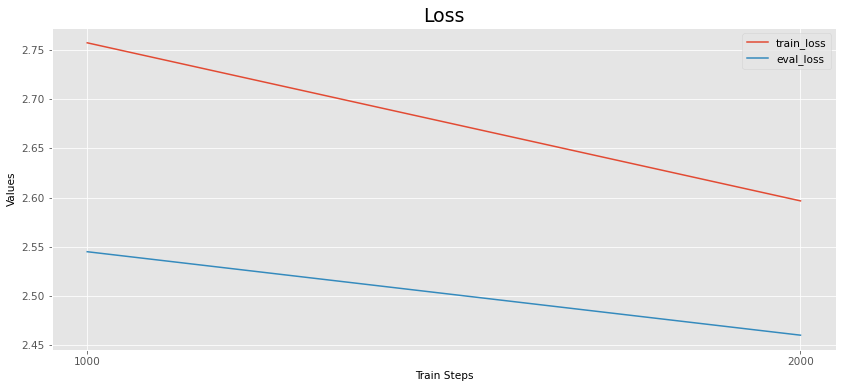

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `2` will be converted to `0.1` as default.
  DeprecationWarning)


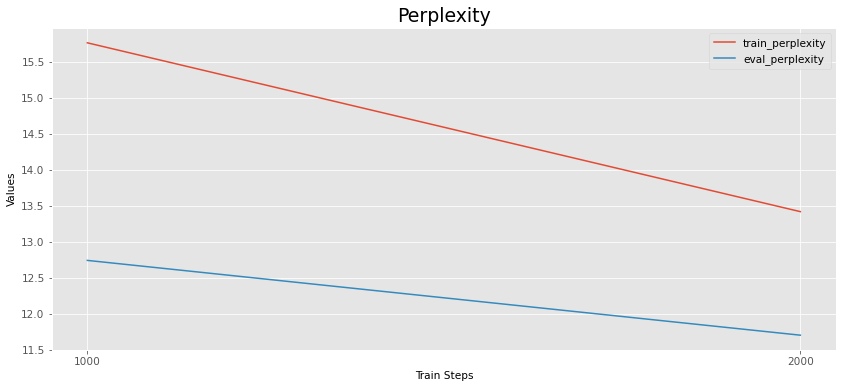

In [ ]:
# Plot Losses.
plot_dict(loss_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='Loss', 
          use_xlabel='Train Steps', use_ylabel='Values', magnify=2)

print()

# Plot Perplexities.
plot_dict(perplexity_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='Perplexity', 
          use_xlabel='Train Steps', use_ylabel='Values', magnify=2)

# **Evaluate**

For the final evaluation we can have a separate test set that we use to do our final perplexity evaluation. For simplicity I used the same validation text file for the final evaluation. That is the reason I get the same results as the last validation perplexity plot value.

In [ ]:
# check if `do_eval` flag is set.
if training_args.do_eval:
  
  # capture output if trainer evaluate.
  eval_output = trainer.evaluate()
  # compute perplexity from model loss.
  perplexity = math.exp(eval_output["eval_loss"])
  print('\nEvaluate Perplexity: {:10,.2f}'.format(perplexity))
else:
  print('No evaluation needed. No evaluation data provided, `do_eval=False`!')

***** Running Evaluation *****
  Num examples = 25712
  Batch size = 100



Evaluate Perplexity:      11.57


ColabからのHTML出力

In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks")
!jupyter nbconvert --to html Adapting_Domein.ipynb

[NbConvertApp] Converting notebook Adapting_Domein.ipynb to html
/usr/local/lib/python2.7/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) [u'application/vnd.colab-display-data+json'] is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Writing 516557 bytes to Adapting_Domein.html
